<a href="https://colab.research.google.com/github/xbeafraid1/ILTAL/blob/main/Python_GBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LGBM 틀+Kfold. 추가변수 없음.



# GPU가 쓰고 싶어요


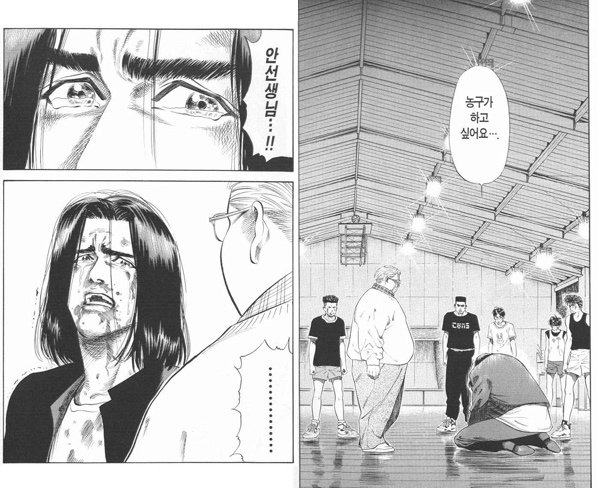


In [ ]:
!git clone --recursive https://github.com/Microsoft/LightGBM

In [ ]:
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time
import torch
import statsmodels.api as sm
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from tqdm import tnrange, tqdm_notebook
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from pandas import DataFrame, concat
import torch
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install import_ipynb
import import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=2b2ab695b8d5fd8063616bcf31069bcfd0196aa13211784ee1ca2697185b0ba4
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 여기에 전처리 함수를 다 모아놓았읍니다.

!cp /content/drive/MyDrive/Jupyter/unlimited_power/rg_defs.ipynb .
import rg_defs as RG

importing Jupyter notebook from rg_defs.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#### 파라미터 ####

# 하루의 틱
ticks = 48

# 예측에 사용할 일수
days = 3                # 이 부분을 바꿀 수 있다.
n_days = ticks*days

# 미래 예측할 일수
future_days = 2
future_window = ticks * future_days

### 모든변수
# ['Hour', 'Minute', 'Day', 'WS', 'Time', 'DHI','DNI','RH','T','TARGET']

# 사용할 변수
what_to_use = ['Time', 'DHI','DNI','RH','T','TARGET']

n_features = len(what_to_use)
n_obs = n_days * n_features # 7일 예측 기준으로 7(일 수) * 48(틱 수) * 6(변수 개수)

In [ ]:
# 데이터 불러오기 

raw_data = pd.read_csv('/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/train/train.csv')
submission = pd.read_csv('/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/sample_submission.csv')
submission.shape

(7776, 10)

In [ ]:
### min_max_scale이나 normalize 하는 경우
### 일단 점수가 안 좋게 나와서 얘는 뺏음


  # df_test = []

  # for i in range(81):
  #     file_path = '/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/test/' + str(i) + '.csv'
  #     temp = pd.read_csv(file_path)
  #     testset = RG.drop_clms(temp)
  #     testset2 = RG.series_to_supervised(testset, n_days, dropnan=False)
  #     testset3 = RG.minmax_scaler(testset2, train=False)
  #     testset4 = testset3.iloc[-ticks:, :]
  #     df_test.append(testset4)

  # X_test = pd.concat(df_test)
  # X_test = X_test.iloc[:, :n_obs]
  # X_test.shape

(3888, 864)

In [ ]:
df_test = []

for i in range(81):
    file_path = '/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    testset = RG.drop_clms(temp)
    testset2 = RG.series_to_supervised(testset, n_days, dropnan=False)
    testset3 = testset2.iloc[-ticks:, :]
    df_test.append(testset3)

X_test = pd.concat(df_test)
X_test = X_test.iloc[:, :n_obs]
X_test.shape

(3888, 864)

In [ ]:
X_test

,var1(t-144),var2(t-144),var3(t-144),var4(t-144),var5(t-144),var6(t-144),var1(t-143),var2(t-143),var3(t-143),var4(t-143),var5(t-143),var6(t-143),var1(t-142),var2(t-142),var3(t-142),var4(t-142),var5(t-142),var6(t-142),var1(t-141),var2(t-141),var3(t-141),var4(t-141),var5(t-141),var6(t-141),var1(t-140),var2(t-140),var3(t-140),var4(t-140),var5(t-140),var6(t-140),var1(t-139),var2(t-139),var3(t-139),var4(t-139),var5(t-139),var6(t-139),var1(t-138),var2(t-138),var3(t-138),var4(t-138),...,var3(t-7),var4(t-7),var5(t-7),var6(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1)
288,0.0,0.0,0.0,59.09,0.1,0.0,0.5,0.0,0.0,61.20,-0.4,0.0,1.0,0.0,0.0,65.76,-0.8,0.0,1.5,0.0,0.0,66.24,-0.9,0.0,2.0,0.0,0.0,69.70,-1.0,0.0,2.5,0.0,0.0,69.70,-1.0,0.0,3.0,0.0,0.0,68.17,...,0.0,83.69,-2.5,0.000000,21.0,0.0,0.0,82.74,-2.6,0.000000,21.5,0.0,0.0,82.74,-2.6,0.000000,22.0,0.0,0.0,82.00,-2.6,0.000000,22.5,0.0,0.0,82.00,-2.6,0.0,23.0,0.0,0.0,81.38,-2.6,0.0,23.5,0.0,0.0,81.99,-2.7,0.0
289,0.5,0.0,0.0,61.20,-0.4,0.0,1.0,0.0,0.0,65.76,-0.8,0.0,1.5,0.0,0.0,66.24,-0.9,0.0,2.0,0.0,0.0,69.70,-1.0,0.0,2.5,0.0,0.0,69.70,-1.0,0.0,3.0,0.0,0.0,68.17,-1.0,0.0,3.5,0.0,0.0,67.68,...,0.0,82.74,-2.6,0.000000,21.5,0.0,0.0,82.74,-2.6,0.000000,22.0,0.0,0.0,82.00,-2.6,0.000000,22.5,0.0,0.0,82.00,-2.6,0.000000,23.0,0.0,0.0,81.38,-2.6,0.0,23.5,0.0,0.0,81.99,-2.7,0.0,0.0,0.0,0.0,80.92,-2.8,0.0
290,1.0,0.0,0.0,65.76,-0.8,0.0,1.5,0.0,0.0,66.24,-0.9,0.0,2.0,0.0,0.0,69.70,-1.0,0.0,2.5,0.0,0.0,69.70,-1.0,0.0,3.0,0.0,0.0,68.17,-1.0,0.0,3.5,0.0,0.0,67.68,-0.9,0.0,4.0,0.0,0.0,64.30,...,0.0,82.74,-2.6,0.000000,22.0,0.0,0.0,82.00,-2.6,0.000000,22.5,0.0,0.0,82.00,-2.6,0.000000,23.0,0.0,0.0,81.38,-2.6,0.000000,23.5,0.0,0.0,81.99,-2.7,0.0,0.0,0.0,0.0,80.92,-2.8,0.0,0.5,0.0,0.0,81.53,-2.9,0.0
291,1.5,0.0,0.0,66.24,-0.9,0.0,2.0,0.0,0.0,69.70,-1.0,0.0,2.5,0.0,0.0,69.70,-1.0,0.0,3.0,0.0,0.0,68.17,-1.0,0.0,3.5,0.0,0.0,67.68,-0.9,0.0,4.0,0.0,0.0,64.30,-0.7,0.0,4.5,0.0,0.0,63.91,...,0.0,82.00,-2.6,0.000000,22.5,0.0,0.0,82.00,-2.6,0.000000,23.0,0.0,0.0,81.38,-2.6,0.000000,23.5,0.0,0.0,81.99,-2.7,0.000000,0.0,0.0,0.0,80.92,-2.8,0.0,0.5,0.0,0.0,81.53,-2.9,0.0,1.0,0.0,0.0,79.91,-3.0,0.0
292,2.0,0.0,0.0,69.70,-1.0,0.0,2.5,0.0,0.0,69.70,-1.0,0.0,3.0,0.0,0.0,68.17,-1.0,0.0,3.5,0.0,0.0,67.68,-0.9,0.0,4.0,0.0,0.0,64.30,-0.7,0.0,4.5,0.0,0.0,63.91,-0.6,0.0,5.0,0.0,0.0,61.34,...,0.0,82.00,-2.6,0.000000,23.0,0.0,0.0,81.38,-2.6,0.000000,23.5,0.0,0.0,81.99,-2.7,0.000000,0.0,0.0,0.0,80.92,-2.8,0.000000,0.5,0.0,0.0,81.53,-2.9,0.0,1.0,0.0,0.0,79.91,-3.0,0.0,1.5,0.0,0.0,79.91,-3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,21.5,0.0,0.0,79.32,12.2,0.0,22.0,0.0,0.0,80.41,11.7,0.0,22.5,0.0,0.0,83.10,11.2,0.0,23.0,0.0,0.0,84.37,10.8,0.0,23.5,0.0,0.0,85.50,10.6,0.0,0.0,0.0,0.0,86.41,10.3,0.0,0.5,0.0,0.0,86.99,...,181.0,41.65,19.4,12.666762,18.5,54.0,126.0,45.74,17.9,6.849547,19.0,21.0,51.0,53.81,16.4,2.251943,19.5,1.0,1.0,55.62,15.9,0.093831,20.0,0.0,0.0,57.52,15.3,0.0,20.5,0.0,0.0,59.77,14.7,0.0,21.0,0.0,0.0,61.34,14.2,0.0
332,22.0,0.0,0.0,80.41,11.7,0.0,22.5,0.0,0.0,83.10,11.2,0.0,23.0,0.0,0.0,84.37,10.8,0.0,23.5,0.0,0.0,85.50,10.6,0.0,0.0,0.0,0.0,86.41,10.3,0.0,0.5,0.0,0.0,86.99,10.2,0.0,1.0,0.0,0.0,86.19,...,126.0,45.74,17.9,6.849547,19.0,21.0,51.0,53.81,16.4,2.251943,19.5,1.0,1.0,55.62,15.9,0.093831,20.0,0.0,0.0,57.52,15.3,0.000000,20.5,0.0,0.0,59.77,14.7,0.0,21.0,0.0,0.0,61.34,14.2,0.0,21.5,0.0,0.0,63.35,13.7,0.0
333,22.5,0.0

In [ ]:
# drop_clms 함수를 이용하여 쓰지 않는 데이터 분리하기

dataset = RG.drop_clms(raw_data)
dataset2 = RG.series_to_supervised(dataset, n_days)
dataset2

,var1(t-144),var2(t-144),var3(t-144),var4(t-144),var5(t-144),var6(t-144),var1(t-143),var2(t-143),var3(t-143),var4(t-143),var5(t-143),var6(t-143),var1(t-142),var2(t-142),var3(t-142),var4(t-142),var5(t-142),var6(t-142),var1(t-141),var2(t-141),var3(t-141),var4(t-141),var5(t-141),var6(t-141),var1(t-140),var2(t-140),var3(t-140),var4(t-140),var5(t-140),var6(t-140),var1(t-139),var2(t-139),var3(t-139),var4(t-139),var5(t-139),var6(t-139),var1(t-138),var2(t-138),var3(t-138),var4(t-138),...,var5(t-7),var6(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),TARGET1(t+48),TARGET1(t+96)
144,0.0,0.0,0.0,69.08,-12.0,0.0,0.5,0.0,0.0,69.06,-12.0,0.0,1.0,0.0,0.0,71.78,-12.0,0.0,1.5,0.0,0.0,71.75,-12.0,0.0,2.0,0.0,0.0,75.20,-12.0,0.0,2.5,0.0,0.0,69.29,-11.0,0.0,3.0,0.0,0.0,72.56,...,-12.0,0.0,21.0,0.0,0.0,82.90,-12.0,0.0,21.5,0.0,0.0,82.89,-12.0,0.0,22.0,0.0,0.0,79.09,-13.0,0.0,22.5,0.0,0.0,79.08,-13.0,0.0,23.0,0.0,0.0,81.09,-13.0,0.0,23.5,0.0,0.0,81.08,-13.0,0.0,0.0,0.0
145,0.5,0.0,0.0,69.06,-12.0,0.0,1.0,0.0,0.0,71.78,-12.0,0.0,1.5,0.0,0.0,71.75,-12.0,0.0,2.0,0.0,0.0,75.20,-12.0,0.0,2.5,0.0,0.0,69.29,-11.0,0.0,3.0,0.0,0.0,72.56,-11.0,0.0,3.5,0.0,0.0,72.55,...,-12.0,0.0,21.5,0.0,0.0,82.89,-12.0,0.0,22.0,0.0,0.0,79.09,-13.0,0.0,22.5,0.0,0.0,79.08,-13.0,0.0,23.0,0.0,0.0,81.09,-13.0,0.0,23.5,0.0,0.0,81.08,-13.0,0.0,0.0,0.0,0.0,77.76,-14.0,0.0,0.0,0.0
146,1.0,0.0,0.0,71.78,-12.0,0.0,1.5,0.0,0.0,71.75,-12.0,0.0,2.0,0.0,0.0,75.20,-12.0,0.0,2.5,0.0,0.0,69.29,-11.0,0.0,3.0,0.0,0.0,72.56,-11.0,0.0,3.5,0.0,0.0,72.55,-11.0,0.0,4.0,0.0,0.0,74.62,...,-12.0,0.0,22.0,0.0,0.0,79.09,-13.0,0.0,22.5,0.0,0.0,79.08,-13.0,0.0,23.0,0.0,0.0,81.09,-13.0,0.0,23.5,0.0,0.0,81.08,-13.0,0.0,0.0,0.0,0.0,77.76,-14.0,0.0,0.5,0.0,0.0,77.77,-13.0,0.0,0.0,0.0
147,1.5,0.0,0.0,71.75,-12.0,0.0,2.0,0.0,0.0,75.20,-12.0,0.0,2.5,0.0,0.0,69.29,-11.0,0.0,3.0,0.0,0.0,72.56,-11.0,0.0,3.5,0.0,0.0,72.55,-11.0,0.0,4.0,0.0,0.0,74.62,-11.0,0.0,4.5,0.0,0.0,74.61,...,-13.0,0.0,22.5,0.0,0.0,79.08,-13.0,0.0,23.0,0.0,0.0,81.09,-13.0,0.0,23.5,0.0,0.0,81.08,-13.0,0.0,0.0,0.0,0.0,77.76,-14.0,0.0,0.5,0.0,0.0,77.77,-13.0,0.0,1.0,0.0,0.0,77.69,-13.0,0.0,0.0,0.0
148,2.0,0.0,0.0,75.20,-12.0,0.0,2.5,0.0,0.0,69.29,-11.0,0.0,3.0,0.0,0.0,72.56,-11.0,0.0,3.5,0.0,0.0,72.55,-11.0,0.0,4.0,0.0,0.0,74.62,-11.0,0.0,4.5,0.0,0.0,74.61,-11.0,0.0,5.0,0.0,0.0,73.74,...,-13.0,0.0,23.0,0.0,0.0,81.09,-13.0,0.0,23.5,0.0,0.0,81.08,-13.0,0.0,0.0,0.0,0.0,77.76,-14.0,0.0,0.5,0.0,0.0,77.77,-13.0,0.0,1.0,0.0,0.0,77.69,-13.0,0.0,1.5,0.0,0.0,71.57,-13.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52459,21.5,0.0,0.0,84.85,-8.0,0.0,22.0,0.0,0.0,82.26,-8.0,0.0,22.5,0.0,0.0,82.25,-8.0,0.0,23.0,0.0,0.0,81.14,-8.0,0.0,23.5,0.0,0.0,81.12,-8.0,0.0,0.0,0.0,0.0,80.36,-8.0,0.0,0.5,0.0,0.0,74.27,...,1.0,0.0,18.5,0.0,0.0,50.32,0.0,0.0,19.0,0.0,0.0,51.78,0.0,0.0,19.5,0.0,0.0,51.77,0.0,0.0,20.0,0.0,0.0,53.88,0.0,0.0,20.5,0.0,0.0,53.87,0.0,0.0,21.0,0.0,0.0,55.98,-1.0,0.0,0.0,0.0
52460,22.0,0.0,0.0,82.26,-8.0,0.0,22.5,0.0,0.0,82.25,-8.0,0.0,23.0,0.0,0.0,81.14,-8.0,0.0,23.5,0.0,0.0,81.12,-8.0,0.0,0.0,0.0,0.0,80.36,-8.0,0.0,0.5,0.0,0.0,74.27,-8.0,0.0,1.0,0.0,0.0,73.57,...,0.0,0.0,19.0,0.0,0.0,51.78,0.0,0.0,19.5,0.0,0.0,51.77,0.0,0.0,20.0,0.0,0.0,53.88,0.0,0.0,20.5,0.0,0.0,53.87,0.0,0.0,21.0,0.0,0.0,55.98,-1.0,0.0,21.5,0.0,0.0,55.97,-1.0,0.0,0.0,0.0
52461,22.5,0.0,0.0,82.25,-8.0,0.0,23.0,0.0,0.0,81.14,-8.0,0.0,23.5,0.0,0.0,81.12,-8.0,0.0,0.0,0.0,0.0,80.36,-8.

In [ ]:
# train_X, train_y, test_X, test_y로 분리하는 함수.

#X_train_1, X_valid_1, Y_train_1, Y_valid_1, X_train_2, X_valid_2, Y_train_2, Y_valid_2 = RG.seperator(dataset2)

#train/valid 분리는 kfold로 대체

X = dataset2.iloc[:, :n_obs]
Y1 = dataset2.iloc[:, -2] #  2일동안 마지막 틱만 추출하여 예측값으로 설정한다. 
Y2 = dataset2.iloc[:, -1]

In [ ]:
# X_train_1

,var1(t-144),var2(t-144),var3(t-144),var4(t-144),var5(t-144),var6(t-144),var1(t-143),var2(t-143),var3(t-143),var4(t-143),var5(t-143),var6(t-143),var1(t-142),var2(t-142),var3(t-142),var4(t-142),var5(t-142),var6(t-142),var1(t-141),var2(t-141),var3(t-141),var4(t-141),var5(t-141),var6(t-141),var1(t-140),var2(t-140),var3(t-140),var4(t-140),var5(t-140),var6(t-140),var1(t-139),var2(t-139),var3(t-139),var4(t-139),var5(t-139),var6(t-139),var1(t-138),var2(t-138),var3(t-138),var4(t-138),...,var3(t-7),var4(t-7),var5(t-7),var6(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1)
1555,9.5,159.0,119.0,62.60,5.0,18.956230,10.0,191.0,135.0,59.19,6.0,23.272739,10.5,210.0,77.0,59.16,6.0,23.085056,11.0,95.0,0.0,59.73,6.0,8.914960,11.5,255.0,149.0,59.69,6.0,31.343124,12.0,218.0,30.0,60.17,6.0,21.958955,12.5,250.0,76.0,60.14,...,0.0,68.02,-2.0,0.000000,6.5,0.0,0.0,63.15,-1.0,0.000000,7.0,0.0,0.0,64.86,-1.0,0.000000,7.5,15.0,0.0,55.99,0.0,1.407718,8.0,49.0,0.0,57.16,1.0,4.598495,8.5,35.0,0.0,57.17,2.0,3.284604,9.0,75.0,0.0,53.50,3.0,7.038359
38121,4.5,0.0,0.0,57.80,-3.0,0.000000,5.0,0.0,0.0,56.51,-3.0,0.000000,5.5,0.0,0.0,56.50,-3.0,0.000000,6.0,0.0,0.0,55.54,-3.0,0.000000,6.5,0.0,0.0,47.81,-1.0,0.000000,7.0,28.0,388.0,47.75,0.0,5.630873,7.5,43.0,627.0,44.37,...,0.0,58.86,3.0,0.000000,1.5,0.0,0.0,63.19,3.0,0.000000,2.0,0.0,0.0,60.08,3.0,0.000000,2.5,0.0,0.0,64.52,2.0,0.000000,3.0,0.0,0.0,60.50,2.0,0.000000,3.5,0.0,0.0,60.48,1.0,0.000000,4.0,0.0,0.0,58.56,1.0,0.000000
4783,15.5,133.0,712.0,18.15,16.0,49.167641,16.0,134.0,583.0,18.52,16.0,38.189370,16.5,55.0,809.0,19.76,14.0,33.873871,17.0,50.0,701.0,30.45,13.0,23.458617,17.5,67.0,220.0,37.18,10.0,10.134457,18.0,33.0,253.0,45.58,8.0,5.161179,18.5,0.0,0.0,52.34,...,945.0,19.79,15.0,88.108630,12.5,133.0,942.0,19.78,15.0,87.264138,13.0,438.0,139.0,20.43,15.0,51.889321,13.5,341.0,35.0,21.80,15.0,34.717991,14.0,154.0,8.0,23.04,15.0,15.013185,14.5,94.0,0.0,24.60,14.0,8.820343,15.0,222.0,18.0,26.82,13.0,21.957266
20757,10.5,180.0,704.0,36.47,14.0,58.739732,11.0,324.0,319.0,34.03,15.0,50.481835,11.5,350.0,271.0,34.01,15.0,50.575667,12.0,301.0,454.0,34.01,16.0,58.456947,12.5,366.0,157.0,36.27,15.0,44.758058,13.0,345.0,95.0,36.38,15.0,38.658952,13.5,103.0,0.0,38.83,...,504.0,49.34,0.0,8.540157,7.5,47.0,690.0,45.89,2.0,18.206088,8.0,58.0,791.0,37.35,4.0,28.059282,8.5,66.0,861.0,34.79,5.0,37.818616,9.0,74.0,901.0,28.37,6.0,46.733161,9.5,79.0,934.0,28.36,7.0,54.802944,10.0,87.0,948.0,26.47,8.0,61.558795
47626,5.0,0.0,0.0,95.50,6.0,0.000000,5.5,0.0,0.0,89.06,7.0,0.000000,6.0,21.0,0.0,83.25,8.0,1.970632,6.5,43.0,399.0,77.71,9.0,9.196182,7.0,59.0,577.0,69.08,11.0,18.391960,7.5,72.0,683.0,60.43,13.0,28.056506,8.0,80.0,761.0,50.93,...,0.0,74.19,8.0,0.000000,2.0,0.0,0.0,74.39,8.0,0.000000,2.5,0.0,0.0,79.74,7.0,0.000000,3.0,0.0,0.0,80.88,7.0,0.000000,3.5,0.0,0.0,80.91,7.0,0.000000,4.0,0.0,0.0,82.34,7.0,0.000000,4.5,0.0,0.0,88.32,6.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11428,2.0,0.0,0.0,49.47,12.0,0.000000,2.5,0.0,0.0,49.46,12.0,0.000000,3.0,0.0,0.0,47.39,12.0,0.000000,3.5,0.0,0.0,47.39,11.0,0.000000,4.0,0.0,0.0,47.81,11.0,0.000000,4.5,0.0,0.0,47.82,11.0,0.000000,5.0,0.0,0.0,50.08,...,0.0,69.17,18.0,0.000000,23.0,0.0,0.0,69.72,18.0,0.000000,23.5,0.0,0.0,74.31,17.0,0.000000,0.0,0.0,0.0,74.06,17.0,0.000000,0.5,0.0,0.0,74.05,16.0,0.000000,1.0,0.0,0.0,73.60,16.0,0.000000,1.5,0.0,0.0,78.49,16.0,0.000000
44876,22.0,0.0,0.0,96.

In [ ]:
# X = dataset2.iloc[:, :n_obs]
# Y1 = dataset2.iloc[:, -2] #  2일동안 마지막 틱만 추출하여 예측값으로 설정한다. 
# Y2 = dataset2.iloc[:, -1]

# # 7 : 3으로 Train Set :  Test Set을, 다시 7 : 3으로 Train Set을 나눈다.

# # X_train_1, X_test_1, Y_train_1,  Y_test_1 = train_test_split(X, Y1, test_size=0.30, random_state=42)
# # X_train_1, X_valid_1, Y_train_1,  Y_valid_1 = train_test_split(X_train_1, Y_train_1, test_size = 0.30, random_state=42)

# # X_train_2, X_test_2, Y_train_2,  Y_test_2 = train_test_split(X, Y2, test_size=0.30, random_state=42)
# # X_train_2, X_valid_2, Y_train_2,  Y_valid_2 = train_test_split(X_train_2, Y_train_2, test_size = 0.30, random_state=42)

# X_train_1, X_valid_1, Y_train_1,  Y_valid_1 = train_test_split(X, Y1, test_size=0.30, random_state=42)
# X_train_2, X_valid_2, Y_train_2,  Y_valid_2 = train_test_split(X, Y2, test_size=0.30, random_state=42)

In [ ]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, cross_val_score

# LGBM 모델을 구축하고 예측까지 하는 함수를 만든다. 
def LGBM(q, X, Y, X_test):
    
    # (a) 모델링
    model = LGBMRegressor(objective='quantile', alpha=q,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, save_binary = True, subsample=0.7, device = 'gpu')          
    
        # bagging_fraction : 배깅을 하기위해서 데이터를 랜덤 샘플링하여 학습에 사용한다. 비율은 0 < fraction <= 1 이며 0이 되지 않게 해야한다.
        # learning_rate : 일반적으로 0.01 ~ 0.1 정도로 맞추고 다른 파라미터를 튜닝한다. 나중에 성능을 더 높일 때 learning rate를 더 줄인다.
        # n_estimators : 기본값은 100, 1000 정도로 해주는 게 좋고 많을 수록 과적합이 발생한 가능성이 높음.
        # save_binary = True 넣어주면 더 빨라진다고 함.
        # https://greatjoy.tistory.com/72

    splits = 4
    kfold = KFold(n_splits = splits, shuffle = True, random_state = 42) 
    oof = np.zeros(len(X))   
    for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(X)):
      X_train, Y_train = X.iloc[trn_idx], Y.iloc[trn_idx]
      X_valid, Y_valid = X.iloc[val_idx], Y.iloc[val_idx]
      
      model.fit(X_train, Y_train, eval_metric = ['quantile'], eval_set=[(X_valid, Y_valid)], early_stopping_rounds=200, verbose=500)

        # verbose : eval metric이 이 숫자만큼의 round가 지난 다음 자동으로 출력된다.
        # early_stopping_rounds : 이 숫자가 가기 전까지 validation score가 증가하지 않으면 round를 멈춘다. 

    # (b) 예측
    pred = pd.Series(model.predict(X_test).round(4))
    return pred, model

In [ ]:
# Target 예측

def train_data(X_train, Y_train, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in quantiles:
        print(q)
        pred, model = LGBM(q, X_train, Y_train, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=quantiles
    
    return LGBM_models, LGBM_actual_pred

In [ ]:
# Target1

models_1, results_1 = train_data(X, Y1, X_test)
results_1.sort_index()[:48]

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 200 rounds
[500]	valid_0's quantile: 1.32748
[1000]	valid_0's quantile: 1.3159
[1500]	valid_0's quantile: 1.31167
[2000]	valid_0's quantile: 1.30718
[2500]	valid_0's quantile: 1.3029
[3000]	valid_0's quantile: 1.29972
Early stopping, best iteration is:
[2916]	valid_0's quantile: 1.29926
Training until validation scores don't improve for 200 rounds
[500]	valid_0's quantile: 1.30668
[1000]	valid_0's quantile: 1.28863
[1500]	valid_0's quantile: 1.28084
[2000]	valid_0's quantile: 1.27596
[2500]	valid_0's quantile: 1.27252
[3000]	valid_0's quantile: 1.27091
[3500]	valid_0's quantile: 1.26992
[4000]	valid_0's quantile: 1.26888
[4500]	valid_0's quantile: 1.26702
[5000]	valid_0's quantile: 1.266
Early stopping, best iteration is:
[5209]	valid_0's quantile: 1.26482
Training until validation scores don't improve for 200 rounds

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [ ]:
# Target2

models_2, results_2 = train_data(X, Y2, X_test)
results_2.sort_index()

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 200 rounds
[500]	valid_0's quantile: 1.35573
[1000]	valid_0's quantile: 1.33722
[1500]	valid_0's quantile: 1.3245
[2000]	valid_0's quantile: 1.31988
[2500]	valid_0's quantile: 1.31581
[3000]	valid_0's quantile: 1.31511
Early stopping, best iteration is:
[3163]	valid_0's quantile: 1.31381
Training until validation scores don't improve for 200 rounds
[500]	valid_0's quantile: 1.35149
[1000]	valid_0's quantile: 1.33308
[1500]	valid_0's quantile: 1.31932
[2000]	valid_0's quantile: 1.31419
[2500]	valid_0's quantile: 1.31188
[3000]	valid_0's quantile: 1.3095
[3500]	valid_0's quantile: 1.30761
[4000]	valid_0's quantile: 1.30584
[4500]	valid_0's quantile: 1.30451
[5000]	valid_0's quantile: 1.30232
[5500]	valid_0's quantile: 1.30134
[6000]	valid_0's quantile: 1.30077
Early stopping, best iteration is:
[5935]	valid_0's quantil

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(results_1.shape, results_2.shape)

(3888, 9) (3888, 9)


In [ ]:
# 출력

submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
submission.to_csv('submission2.csv')
!cp submission2.csv "drive/My Drive/"